<h1>
<center>Predicting Insurance Purchase using Neural Networks</center>
</h1>

<h1>
<center>Avery Lee</center>
</h1>

# Binary classification DNN (Deep Neural Networks)

Dataset: [Caravan insurance data](https://liacs.leidenuniv.nl/~puttenpwhvander/library/cc2000/). The data gives sociodemographic and product ownership data from customers of an insurance company, some of which purchased caravan insurance. 

The target variable is `Purchase`, which is binary so should be converted to 1 for `Yes` and 0 for `No`.

Load, split and preprocess the data. Train/Val/Test: 65/15/20. We stratify using the target because this is an imbalanced dataset. The features `MOSTYPE` and `MOSHOOFD` are categorical so one hot encoding needs to be applied to them. All other features are numerical so a standard scaler needs to be applied to them. 

In [ ]:
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# load 
caravan = pd.read_csv('/Users/averylee/Desktop/DS/Predicting_Insurance_Purchase_Using_Neural_Networks/caravan.csv')

# target variable (yes/no --> 1/0)
caravan['Purchase'].replace(('Yes', 'No'), (1, 0), inplace=True)

# split - 64% train, 16% val, 20% test
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(caravan, caravan["Purchase"]):
    strat_train_set = caravan.loc[train_index]
    strat_test_set = caravan.loc[test_index]
    
# Split the traning set into training and validation    
split2 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index2, valid_index in split2.split(strat_train_set, strat_train_set["Purchase"]):
    strat_train2_set = strat_train_set.iloc[train_index2]
    strat_valid_set = strat_train_set.iloc[valid_index]

# preprocess 
strat_train_set = strat_train2_set.copy()
strat_valid_set = strat_valid_set.copy()
strat_test_set = strat_test_set.copy()

X_raw = strat_train_set.copy().drop("Purchase", axis=1)
y_train = strat_train_set["Purchase"].copy()

num_pipeline = Pipeline([
        ('std_scaler', StandardScaler()),
    ])
num_features = X_raw.drop("MOSTYPE", axis=1).drop('MOSHOOFD', axis=1)
num_attribs = list(num_features)
cat_attribs = ["MOSTYPE", 'MOSHOOFD']
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

# Apply the pipeline to the training set
X_train = full_pipeline.fit_transform(X_raw)

# Apply the pipeline to the validation set
X_valid_raw = strat_valid_set.drop("Purchase", axis=1)
y_valid = strat_valid_set["Purchase"].copy()
X_valid = full_pipeline.transform(X_valid_raw)

# Apply the pipeline to the validation set
X_test_raw = strat_test_set.drop("Purchase", axis=1)
y_test = strat_test_set["Purchase"].copy()
X_test = full_pipeline.transform(X_test_raw)

In [ ]:
X_train.shape, X_valid.shape, X_test.shape

((3725, 133), (932, 133), (1165, 133))

In [ ]:
y_train.shape, y_valid.shape, y_test.shape

((3725,), (932,), (1165,))

In [ ]:
print(X_train)

[[-0.26920841  0.40025864  0.00630108 ...  0.          0.
   0.        ]
 [-0.26920841 -0.87080994  1.24164497 ...  0.          0.
   0.        ]
 [-0.26920841 -0.87080994  0.00630108 ...  1.          0.
   0.        ]
 ...
 [-0.26920841  1.67132722  0.00630108 ...  0.          0.
   0.        ]
 [-0.26920841  0.40025864 -1.2290428  ...  0.          0.
   0.        ]
 [-0.26920841  0.40025864  0.00630108 ...  1.          0.
   0.        ]]


In [ ]:
print(y_train)

5356    0
2968    0
1180    0
5182    0
2623    0
       ..
219     0
1701    0
5360    0
978     0
4062    0
Name: Purchase, Length: 3725, dtype: int64


Now we can build and fit a DNN with 5 hidden layers of 200, 200, 100, 100, 50 neurons, respectively. We use:

(i) HE initialization and the ELU activation function. ELU ensures sign matching with the input's sign and doesn't have zero gradient. So it solves problems from ReLU like the vanishing gradients and leaky-ReLU. We want to use HE initialization for ELU to ensure optimal variance.

(ii) The output layer has 1 neuron with sigmoid activation. Since we are doing binary classification instead of multiple classes, we can do 1 output neuron. And sigmoid is often used for binary classification since it is smooth.

(iii) Compile with `loss="binary_crossentropy"` and  `metrics=["AUC"]` (which is ROC AUC). For binary classification, we can often use the binary_crossentropy loss function. The AUC will get the area under the curve which is a classification metric for its accuracy so this is appropriate for binary classification. 

We can train the model for 30 epochs and use exponential scheduling and the NAG optimizer with `momentum=0.9`. We can use a learning curve to see if it is overfitting; it does seem to be overfitting since we see the validation error increase more and more while the training error decreases more and more. The gap between the two keeps increasing so it is likely there is overfitting happening. 

In [ ]:
import random as python_random
import tensorflow as tf
import numpy as np
from tensorflow.keras import Sequential, layers
import tensorflow.keras as keras
import matplotlib.pyplot as plt

def reset_session(seed=42):
    tf.random.set_seed(seed)
    python_random.seed(seed)
    np.random.seed(seed)
    tf.keras.backend.clear_session()

def exponential_decay(lr0, s):
    return lambda epoch: lr0 * 0.1**(epoch / s)

In [ ]:
reset_session()

bc_model = Sequential([
    layers.Flatten(input_shape=X_train.shape[1:]),
    layers.Dense(200, activation="elu", kernel_initializer='he_normal'),
    layers.Dense(200, activation="elu", kernel_initializer='he_normal'),
    layers.Dense(100, activation="elu", kernel_initializer='he_normal'),
    layers.Dense(100, activation="elu", kernel_initializer='he_normal'),
    layers.Dense(50, activation="elu", kernel_initializer='he_normal'),
    layers.Dense(1, activation='sigmoid')
])

optimizer = keras.optimizers.SGD(momentum=0.9, nesterov=True)

bc_model.compile(loss='binary_crossentropy',
                 metrics=['AUC'],
                 optimizer=optimizer)

lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay(lr0=0.01,s=20))

run = bc_model.fit(X_train, y_train, epochs=30, verbose=0,
                   validation_data=(X_valid, y_valid),
                   callbacks=[lr_scheduler])

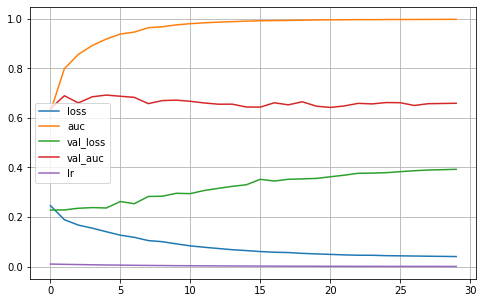

In [ ]:
bc_df = pd.DataFrame(run.history)
bc_df.plot(figsize=(8, 5))
plt.grid(True)
plt.show()

Let's try fitting separate models using the same specification as above but with the following regularization techniques:

(i) batch normalization,

(ii) early stopping based on validation AUC with `patience=10` (look at the documentation and note the `mode` argument).

(iii) $\ell_2$ regularization with `l2=0.001`,

(iv) dropout with probability 0.2,

(v) $\ell_2$ regularization and early stopping both as above,

(vi) batch normalization and dropout both as above.

At the start of each one of the above models, run `reset_session()`.

The performance measure is validation AUC. 

Based on the results given below, (ii), (iii), (iv) (v), (vi) have better validation AUC than the above model and (i) has worse validation AUC than the above model.

In [ ]:
# batch normalization 
reset_session()

bc_model_i = Sequential([
    layers.Flatten(input_shape=X_train.shape[1:]),
    layers.BatchNormalization(),
    layers.Dense(200, activation="elu", kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Dense(200, activation="elu", kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Dense(100, activation="elu", kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Dense(100, activation="elu", kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Dense(50, activation="elu", kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Dense(1, activation='sigmoid')
])

optimizer = keras.optimizers.SGD(momentum=0.9, nesterov=True)

bc_model_i.compile(loss='binary_crossentropy',
                   metrics=['AUC'],
                   optimizer=optimizer)

lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay(lr0=0.01,s=20))

run_i = bc_model_i.fit(X_train, y_train, epochs=30, verbose=0,
                       validation_data=(X_valid, y_valid),
                       callbacks=[lr_scheduler])

In [ ]:
# early stoppping 
reset_session()

bc_model_ii = Sequential([
    layers.Flatten(input_shape=X_train.shape[1:]),
    layers.Dense(200, activation="elu", kernel_initializer='he_normal'),
    layers.Dense(200, activation="elu", kernel_initializer='he_normal'),
    layers.Dense(100, activation="elu", kernel_initializer='he_normal'),
    layers.Dense(100, activation="elu", kernel_initializer='he_normal'),
    layers.Dense(50, activation="elu", kernel_initializer='he_normal'),
    layers.Dense(1, activation='sigmoid')
])

optimizer = keras.optimizers.SGD(momentum=0.9, nesterov=True)

bc_model_ii.compile(loss='binary_crossentropy',
                   metrics=['AUC'],
                   optimizer=optimizer)

lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay(lr0=0.01,s=20))
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10)

run_ii = bc_model_ii.fit(X_train, y_train, epochs=30, verbose=0,
                       validation_data=(X_valid, y_valid),
                       callbacks=[lr_scheduler, early_stopping_cb])

In [ ]:
# l2=0.001
reset_session()

l2 = 0.001
bc_model_iii = Sequential([
    layers.Flatten(input_shape=X_train.shape[1:]),
    layers.Dense(200, activation="elu", kernel_initializer='he_normal', 
                 kernel_regularizer=keras.regularizers.l2(l2)),
    layers.Dense(200, activation="elu", kernel_initializer='he_normal',
                 kernel_regularizer=keras.regularizers.l2(l2)),
    layers.Dense(100, activation="elu", kernel_initializer='he_normal',
                 kernel_regularizer=keras.regularizers.l2(l2)),
    layers.Dense(100, activation="elu", kernel_initializer='he_normal',
                 kernel_regularizer=keras.regularizers.l2(l2)),
    layers.Dense(50, activation="elu", kernel_initializer='he_normal',
                 kernel_regularizer=keras.regularizers.l2(l2)),
    layers.Dense(1, activation='sigmoid')
])

optimizer = keras.optimizers.SGD(momentum=0.9, nesterov=True)

bc_model_iii.compile(loss='binary_crossentropy',
                   metrics=['AUC'],
                   optimizer=optimizer)

lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay(lr0=0.01,s=20))

run_iii = bc_model_iii.fit(X_train, y_train, epochs=30, verbose=0,
                       validation_data=(X_valid, y_valid),
                       callbacks=[lr_scheduler])

In [ ]:
# dropout probability=0.2
reset_session()

dropoutp = 0.2
bc_model_iv = Sequential([
    layers.Flatten(input_shape=X_train.shape[1:]),
    layers.Dropout(rate=dropoutp),
    layers.Dense(200, activation="elu", kernel_initializer='he_normal'),
    layers.Dropout(rate=dropoutp),
    layers.Dense(200, activation="elu", kernel_initializer='he_normal'),
    layers.Dropout(rate=dropoutp),
    layers.Dense(100, activation="elu", kernel_initializer='he_normal'),
    layers.Dropout(rate=dropoutp),
    layers.Dense(100, activation="elu", kernel_initializer='he_normal'),
    layers.Dropout(rate=dropoutp),
    layers.Dense(50, activation="elu", kernel_initializer='he_normal'),
    layers.Dropout(rate=dropoutp),
    layers.Dense(1, activation='sigmoid')
])

optimizer = keras.optimizers.SGD(momentum=0.9, nesterov=True)

bc_model_iv.compile(loss='binary_crossentropy',
                   metrics=['AUC'],
                   optimizer=optimizer)

lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay(lr0=0.01,s=20))

run_iv = bc_model_iv.fit(X_train, y_train, epochs=30, verbose=0,
                       validation_data=(X_valid, y_valid),
                       callbacks=[lr_scheduler])

In [ ]:
# l2=0.001 & early stopping 
reset_session()

l2 = 0.001
bc_model_v = Sequential([
    layers.Flatten(input_shape=X_train.shape[1:]),
    layers.Dense(200, activation="elu", kernel_initializer='he_normal', 
                 kernel_regularizer=keras.regularizers.l2(l2)),
    layers.Dense(200, activation="elu", kernel_initializer='he_normal',
                 kernel_regularizer=keras.regularizers.l2(l2)),
    layers.Dense(100, activation="elu", kernel_initializer='he_normal',
                 kernel_regularizer=keras.regularizers.l2(l2)),
    layers.Dense(100, activation="elu", kernel_initializer='he_normal',
                 kernel_regularizer=keras.regularizers.l2(l2)),
    layers.Dense(50, activation="elu", kernel_initializer='he_normal',
                 kernel_regularizer=keras.regularizers.l2(l2)),
    layers.Dense(1, activation='sigmoid')
])

optimizer = keras.optimizers.SGD(momentum=0.9, nesterov=True)

bc_model_v.compile(loss='binary_crossentropy',
                   metrics=['AUC'],
                   optimizer=optimizer)

lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay(lr0=0.01,s=20))
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10)

run_v = bc_model_v.fit(X_train, y_train, epochs=30, verbose=0,
                       validation_data=(X_valid, y_valid),
                       callbacks=[lr_scheduler, early_stopping_cb])

In [ ]:
# batch normamlization & dropout 
reset_session()

dropoutp = 0.2
bc_model_vi = Sequential([
    layers.Flatten(input_shape=X_train.shape[1:]),
    layers.BatchNormalization(),
    layers.Dropout(rate=dropoutp),
    layers.Dense(200, activation="elu", kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Dropout(rate=dropoutp),
    layers.Dense(200, activation="elu", kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Dropout(rate=dropoutp),
    layers.Dense(100, activation="elu", kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Dropout(rate=dropoutp),
    layers.Dense(100, activation="elu", kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Dropout(rate=dropoutp),
    layers.Dense(50, activation="elu", kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Dropout(rate=dropoutp),
    layers.Dense(1, activation='sigmoid')
])

optimizer = keras.optimizers.SGD(momentum=0.9, nesterov=True)

bc_model_vi.compile(loss='binary_crossentropy',
                   metrics=['AUC'],
                   optimizer=optimizer)

lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay(lr0=0.01,s=20))

run_vi = bc_model_vi.fit(X_train, y_train, epochs=30, verbose=0,
                       validation_data=(X_valid, y_valid),
                       callbacks=[lr_scheduler])

In [ ]:
# evaluate 
def valid_eval(model):
    # returns the model's validation auc 
    return model.evaluate(X_valid, y_valid)[1] 

eval_default = valid_eval(bc_model)
eval_i = valid_eval(bc_model_i)
eval_ii = valid_eval(bc_model_ii)
eval_iii = valid_eval(bc_model_iii)
eval_iv = valid_eval(bc_model_iv)
eval_v = valid_eval(bc_model_v)
eval_vi = valid_eval(bc_model_vi)

aucs = pd.DataFrame({'Default': [eval_default],
                     'BN': [eval_i],
                     'Early Stop': [eval_ii],
                     'L2': [eval_iii],
                     'Dropout': [eval_iv],
                     'L2 + Early Stop': [eval_v],
                     'BN + Dropout': [eval_vi]}, index=['AUC']).transpose()
print(aucs.iloc[np.argmax(aucs)])
aucs

30/30 [==============================] - 0s 3ms/step - loss: 0.2174 - auc: 0.6830
AUC    0.692841
Name: Dropout, dtype: float64


,AUC
Default,0.658971
BN,0.628231
Early Stop,0.666860
L2,0.669989
Dropout,0.692841
L2 + Early Stop,0.669989
BN + Dropout,0.682954


Based on the two plots below for the above models, it seems (iv) is overfitting less since the difference between the training and validation error is less.

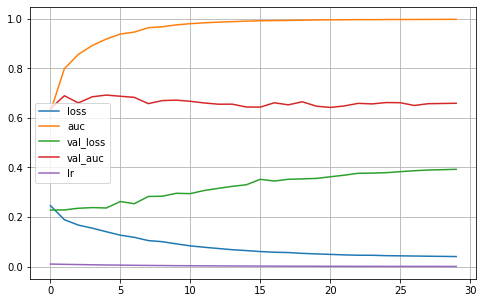

In [ ]:
# default 
bc_df.plot(figsize=(8, 5))
plt.grid(True)
plt.show()

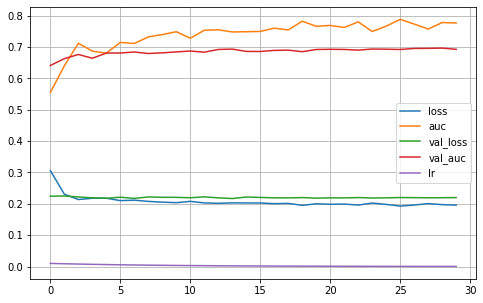

In [ ]:
# dropout 
bc_df_iv = pd.DataFrame(run_iv.history)
bc_df_iv.plot(figsize=(8, 5))
plt.grid(True)
plt.show()

The validation (that we calculated above) and testing AUC are similar, but the testing one is slightly less than the validation. 0's are predicted well but there are quite a few false negatives and false positives. 

In [ ]:
from sklearn.metrics import confusion_matrix

test_auc_v = bc_model_v.evaluate(X_test, y_test)[1] 
test_auc_v

37/37 [==============================] - 0s 2ms/step - loss: 1.2133 - auc: 0.6121


0.6121461391448975

In [ ]:
y_pred_v = np.round(bc_model_v.predict(X_test))
pd.DataFrame(confusion_matrix(y_test, y_pred_v, labels=[0,1]))

,0,1
0,1076,19
1,65,5
